# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

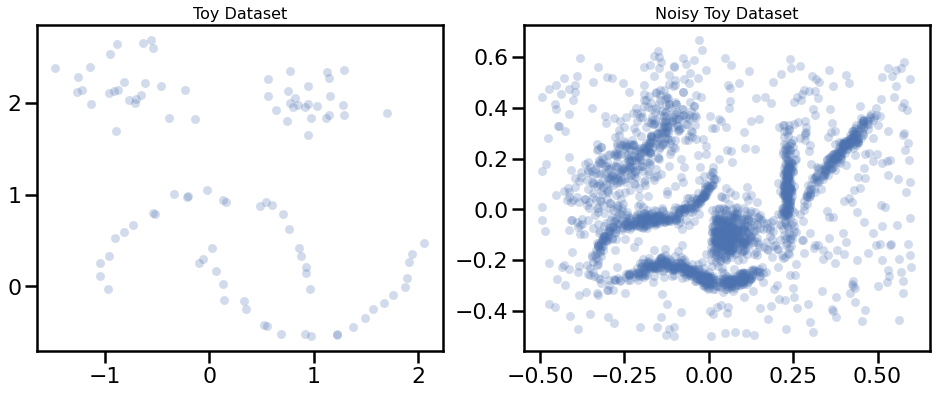

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

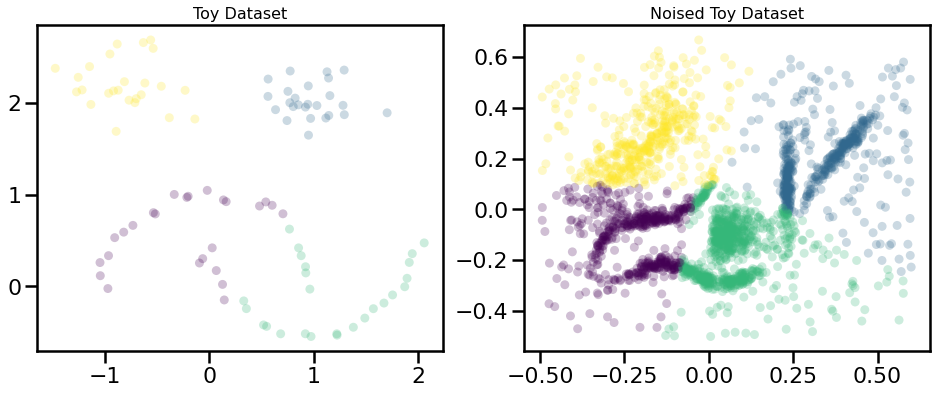

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [4]:
from scipy.spatial import distance
from scipy.spatial import distance_matrix
import pandas as pd 
from scipy.cluster.hierarchy import dendrogram, linkage

class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric = metric
        self.n_clusters = n_clusters
        self.linkage_matrix = None
        self.labels = None
        self.hierarchy = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # Compute the distance matrix
        if self.metric is "euclidean":
            dist_matrix = distance_matrix(X, X)
        else:
            dist_matrix = X
        # Fill the diagonal with infinity
        np.fill_diagonal(dist_matrix, float('inf'))
        dist_matrix = pd.DataFrame(dist_matrix)
        n = len(dist_matrix)
        # initialize the hiearchy vectors
        self.hierarchy = [list(range(n))]
        self.linkage_matrix = np.zeros((n-1,4))
        for k in tqdm(range(n-1)):
            # Look for the coordinates of the couple of cluster that reach the minimum distance
            min_dist = dist_matrix.min().min()
            coordinates_min = dist_matrix.loc[dist_matrix.isin([min_dist]).any(axis=1)].index.tolist()
            i, j =  coordinates_min[0], coordinates_min[len(coordinates_min)//2]# Get coordinates for each cluster that are going to be merged
            # Update self.linkage_matrix
            num_orig_points = self.hierarchy[-1].count(i) + self.hierarchy[-1].count(j)
            self.linkage_matrix[k][:] = [i, j, min_dist, num_orig_points]
            # Update self.hierarchy_
            new_label_assignement = [n+k if x in [i, j] else x for x in self.hierarchy[-1]]
            self.hierarchy.append(new_label_assignement)
            # Update the distance matrix
            dist_matrix = self.update_distance_matrix(dist_matrix, i, j, n+k)
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''   
        plt.figure(figsize=(10, 7))
        dendrogram(self.linkage_matrix)
        plt.show()
    
    @staticmethod
    def update_distance_matrix(matrix_distance, i, j, new):
        # new_vector_cluster is the vector where the i element is min(matrix_distance[i], matrix_distance[j])
        new_vector_cluster = np.minimum(matrix_distance[i], matrix_distance[j])
        # Then we added it to the distance matrix
        # First as a column
        matrix_distance[new] = new_vector_cluster
        # And the row
        matrix_distance.loc[new] = np.append(new_vector_cluster, float('inf'))
        # drop the old clusters
        matrix_distance = matrix_distance.drop([i,j], axis=0)
        matrix_distance = matrix_distance.drop([i,j], axis=1)
        return matrix_distance

Apply the method to your dataset

In [11]:
# First the non noisy toy dataset
model = my_SingleLinkageAglomerativeClustering()
model.fit(test_data_0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


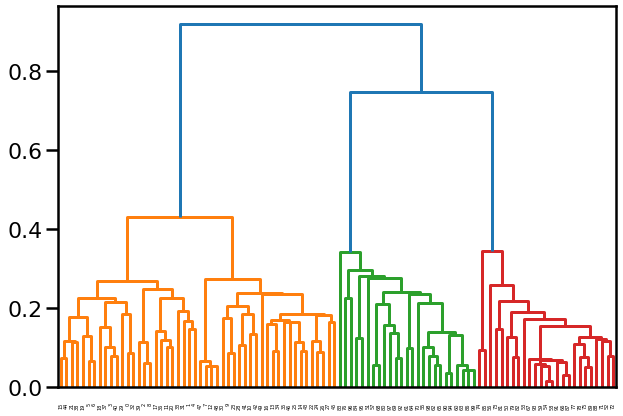

In [6]:
model.plot_dendrogram()

As we can see, there are 3/4 clusters (orange, green, red (two clusters for the orange one) )

Try the different linkage methods implemented in `sklearn`  and comment

Text(0.5, 1.0, 'Dendrogram with linkage method WARD')

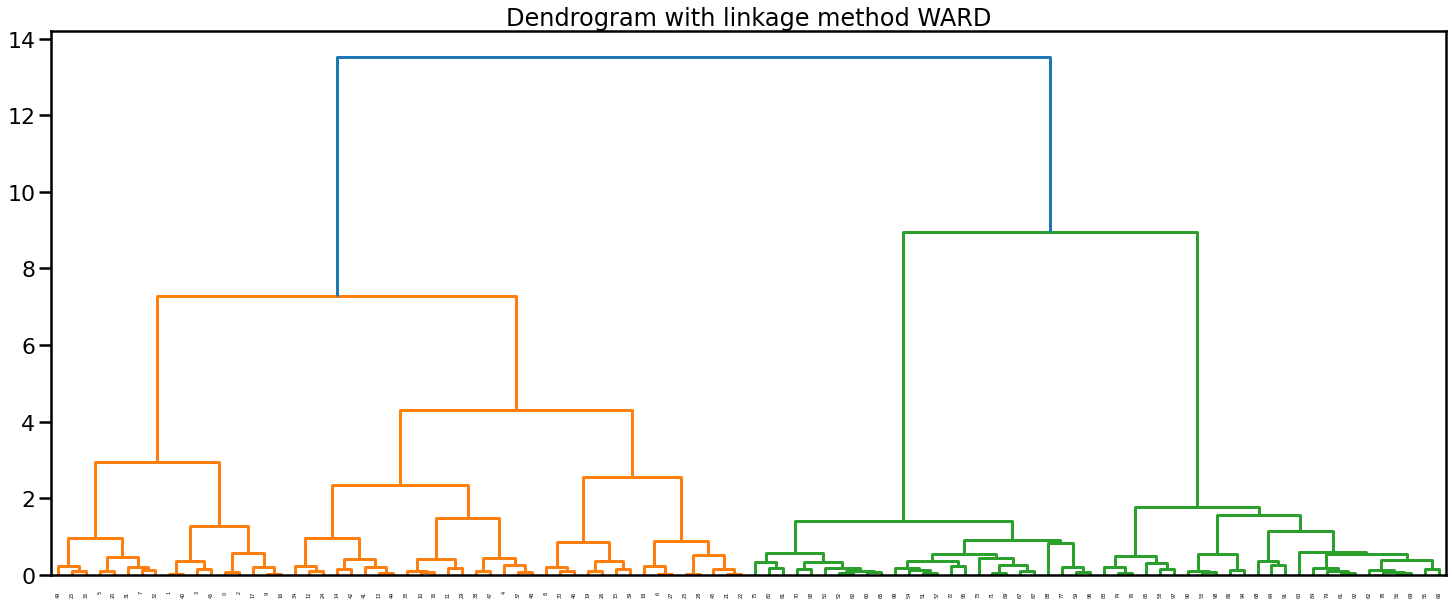

In [35]:
Z = linkage(test_data_0, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.title('Dendrogram with linkage method WARD')

Text(0.5, 1.0, 'Dendrogram with linkage method SINGLE')

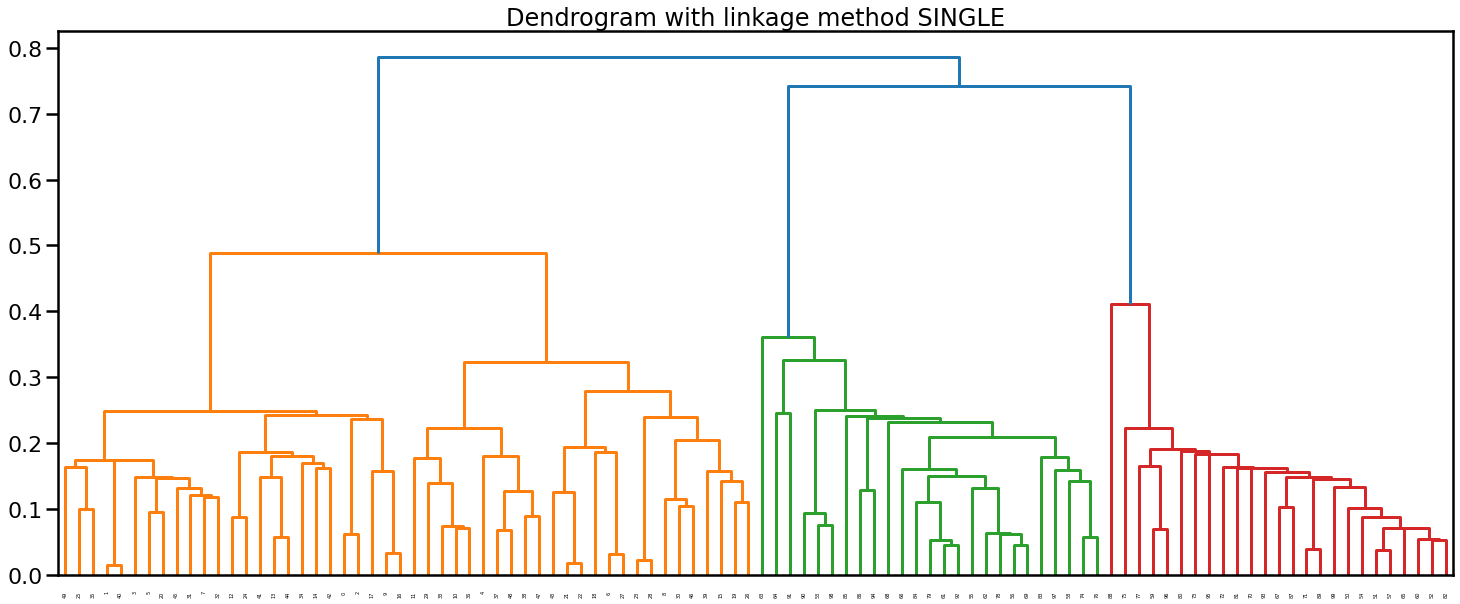

In [36]:
Z = linkage(test_data_0, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.title('Dendrogram with linkage method SINGLE')

Text(0.5, 1.0, 'Dendrogram with linkage method COMPLETE')

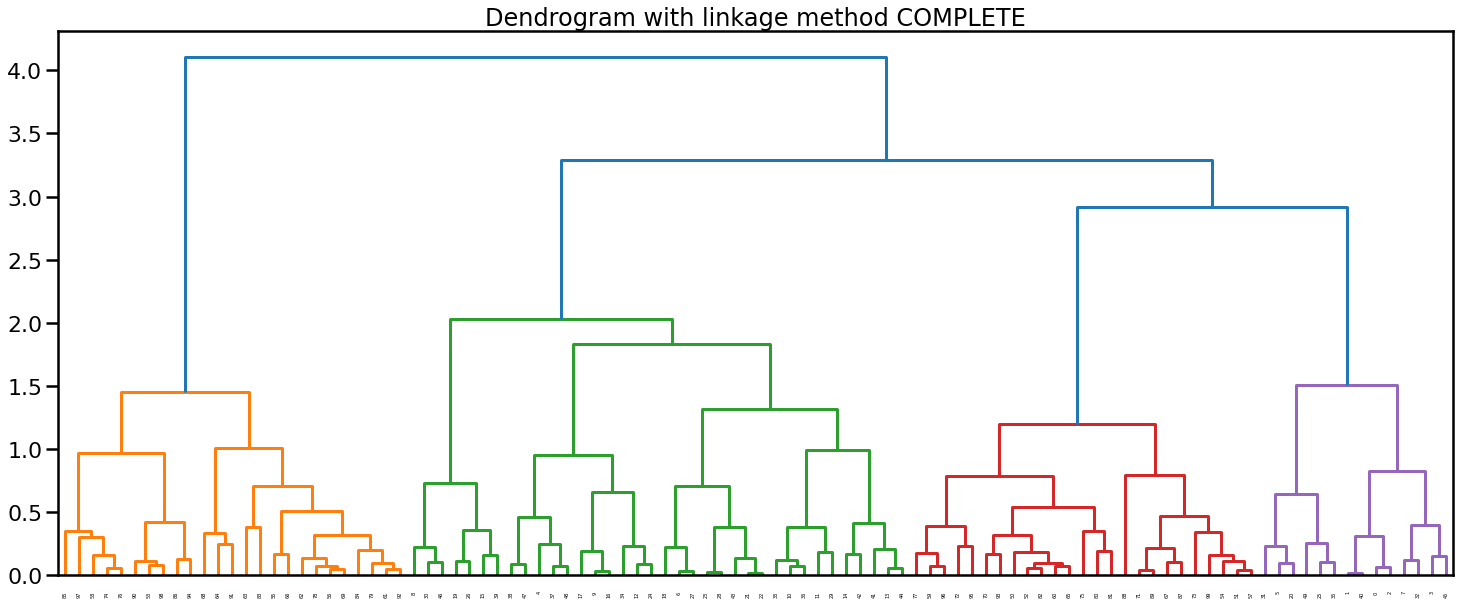

In [37]:
Z = linkage(test_data_0, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.title('Dendrogram with linkage method COMPLETE')

Text(0.5, 1.0, 'Dendrogram with linkage method CENTROID')

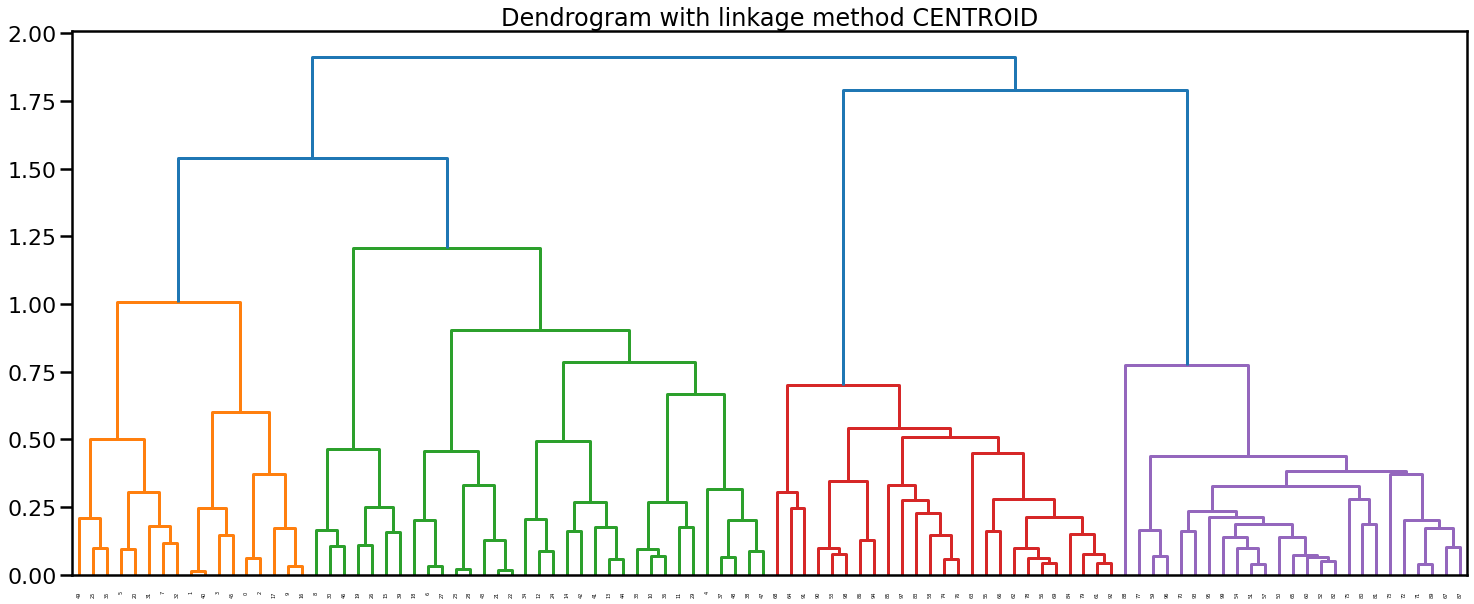

In [38]:
Z = linkage(test_data_0, 'centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.title('Dendrogram with linkage method CENTROID')

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

In [15]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.3, min_samples=5)
model.fit(test_data_0)

DBSCAN(eps=0.3)

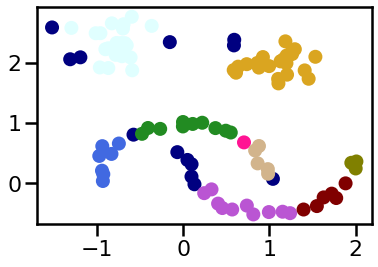

In [19]:
clusters = model.labels_
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(test_data_0[:,0], test_data_0[:,1], c=vectorizer(clusters))

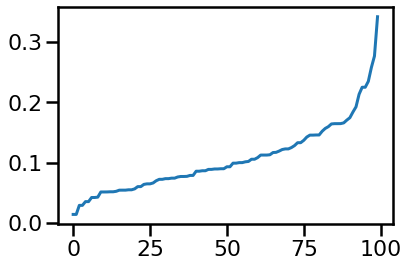

In [20]:
# Find the best epsilon
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(test_data_0)
distances, indices = nbrs.kneighbors(test_data_0)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The optimal value for epsilon will be found at the point of maximum curvature, here it's for epsilon = 0.2

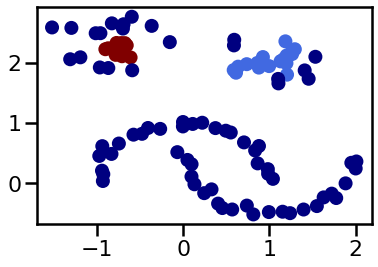

In [30]:
model = DBSCAN(eps=0.20, min_samples=5)
model.fit(test_data_0)
clusters = model.labels_
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(test_data_0[:,0], test_data_0[:,1], c=vectorizer(clusters))

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [16]:
import hdbscan
clusterer = hdbscan.HDBSCAN()
clusterer.fit(test_data_0)

HDBSCAN()

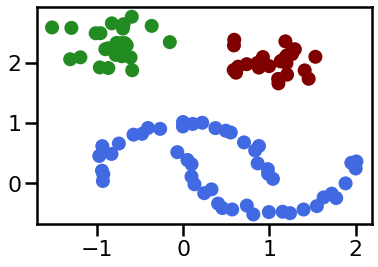

In [33]:
clusters = clusterer.labels_
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(test_data_0[:,0], test_data_0[:,1], c=vectorizer(clusters))

It works better than DBSCAN ..

## Apply the algorithms to the following images and comment the results

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

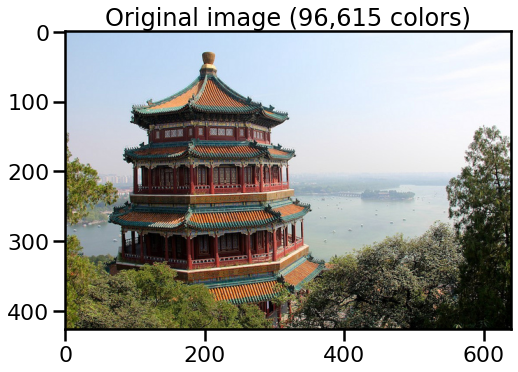

In [29]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.title('Original image (96,615 colors)')
plt.imshow(china);

In [27]:
x,y,z = china.shape
china_reshape = china.reshape(x*y,z) / 255

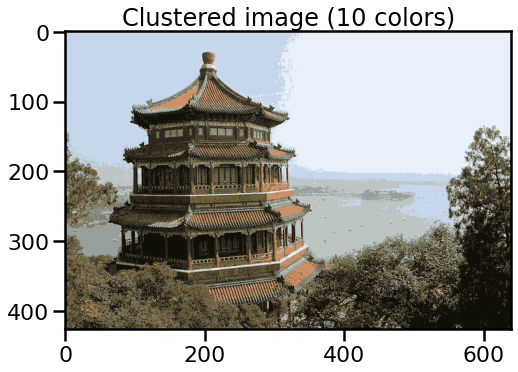

In [30]:
kmeans_china = KMeans(n_clusters=10, max_iter=200)
kmeans_china.fit(china_reshape)
center_clusters = kmeans_china.cluster_centers_
label_clusters = kmeans_china.labels_
def recreate_image(clusters, labels, w, h):
    d = clusters.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = clusters[labels[label_idx]]
            label_idx += 1
    return image
plt.figure(figsize=(8,6))
plt.title('Clustered image (10 colors)')
plt.imshow(recreate_image(center_clusters, label_clusters, x, y))